# Распознавание лиц при помощи SVM и kernel trick

In [598]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.metrics.pairwise import cosine_similarity

# Описание набора данных

В этом задании вам предлагается построить классификатор, обученный на изображениях лиц. Сначала загрузим необходимый набор данных и посмотрим, что он из себя представляет. 

Таблица содержит "распрямленные" представления изображений лиц людей.

Изначально каждое изображение — матрица размера $62 \times 47$, значения которой, предположительно, нормированы к диапазону $[0, 1]$ из диапазона $[0, 255] \cap \mathbb Z$. Сами значения отвечают за интенсивность пикселя: чем значение больше, тем пиксель светлее.

Обратите внимание, из картинки (или, что то же самое, матрицы) размера $62 \times 47$ получился вектор длины $2914 = 62 \cdot 47$.

Колонка <code>label</code> отвечает за имя человека, изображенного на картинке.

In [599]:
df = pd.read_csv('/Users/muzafarov/Desktop/MyEducation/ML_OE/persons_pics_train.csv')
df

,0,1,2,3,4,5,6,7,8,9,...,2905,2906,2907,2908,2909,2910,2911,2912,2913,label
0,0.379085,0.312418,0.352941,0.445752,0.466667,0.473203,0.484967,0.513725,0.545098,0.571242,...,0.597386,0.620915,0.732026,0.852288,0.921569,0.937255,0.941176,0.950327,0.946405,John Ashcroft
1,0.450980,0.466667,0.512418,0.509804,0.450980,0.458824,0.516340,0.571242,0.607843,0.618301,...,0.430065,0.453595,0.679739,0.934640,0.985621,0.981699,0.963399,0.938562,0.874510,Ariel Sharon
2,0.589542,0.614379,0.688889,0.729412,0.738562,0.775163,0.789543,0.806536,0.820915,0.837908,...,0.733333,0.854902,0.937255,0.624837,0.128105,0.082353,0.107190,0.095425,0.100654,Colin Powell
3,0.390850,0.432680,0.499346,0.562091,0.597386,0.644444,0.670588,0.650980,0.637908,0.639216,...,0.713726,0.898039,0.968627,0.959477,0.832680,0.443137,0.266667,0.303268,0.313725,Jean Chretien
4,0.645752,0.626144,0.605229,0.585621,0.602614,0.664052,0.701961,0.709804,0.733333,0.771242,...,0.115033,0.129412,0.132026,0.129412,0.155556,0.171242,0.167320,0.176471,0.183007,Colin Powell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1321,0.237908,0.273203,0.244444,0.332026,0.590850,0.675817,0.684967,0.733333,0.771242,0.771242,...,0.686275,0.694118,0.720261,0.746405,0.756863,0.735948,0.715033,0.684967,0.657516,Tony Blair
1322,0.105882,0.087582,0.117647,0.260131,0.385621,0.466667,0.566013,0.657516,0.692810,0.691503,...,0.722876,0.376471,0.188235,0.139869,0.188235,0.226144,0.243137,0.248366,0.244444,Gerhard Schroeder
1323,0.322876,0.345098,0.369935,0.375163,0.405229,0.464052,0.494118,0.511111,0.517647,0.495425,...,0.465359,0.486274,0.505882,0.535948,0.550327,0.551634,0.552941,0.554248,0.563399,George W Bush
1324,0.304575,0.290196,0.366013,0.444444,0.456209,0.465359,0.479739,0.532026,0.585621,0.603922,...,0.513725,0.802614,0.942484,0.933333,0.707190,0.223529,0.124183,0.133333,0.113725,George W Bush


In [600]:
df['label']

0           John Ashcroft
1            Ariel Sharon
2            Colin Powell
3           Jean Chretien
4            Colin Powell
              ...        
1321           Tony Blair
1322    Gerhard Schroeder
1323        George W Bush
1324        George W Bush
1325      Serena Williams
Name: label, Length: 1326, dtype: object

Убедимся в том, что перед нами действительно изображения лиц людей. Возьмем первые $15$ строк из таблицы исходных данных и построим соответствующие им изображения.

In [601]:
import matplotlib.pyplot as plt

def get_img_by_row(row):
  return row.drop('label').astype(float).to_numpy().reshape(62,47), row['label']

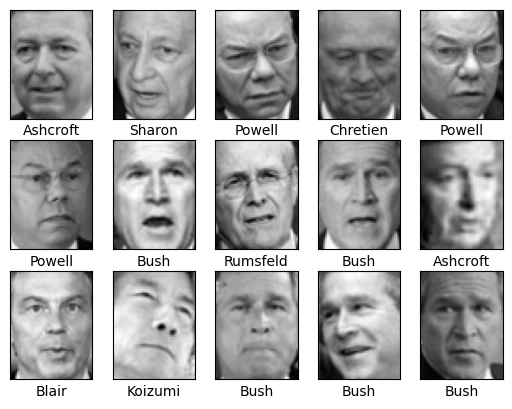

In [602]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    img, lbl = get_img_by_row(df.iloc[i])
    axi.imshow(img, cmap='gray')
    axi.set(xticks=[], yticks=[],
            xlabel=lbl.split()[-1])
plt.savefig('persons_pics_img_for_description.png', dpi = 100, bbox_inches='tight')    

Крупнее

(-0.5, 46.5, 61.5, -0.5)

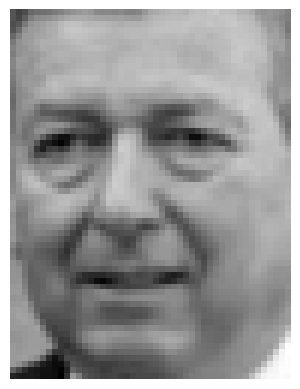

In [603]:
plt.imshow(df.iloc[0].drop('label').astype(float).to_numpy().reshape(62,47), cmap='gray')
plt.axis('off')

# Немного озорства

Определите число различных людей, фотографии которых содержатся в рассматриваемом наборе данных.

In [604]:
count_face = len(df['label'].value_counts())
count_face

12

Постройте гистограмму распределения объектов по классам и вычислите долю объектов каждого класса. 

In [605]:
df['label'].value_counts(1)

label
George W Bush        0.340121
Colin Powell         0.151584
Tony Blair           0.092006
Donald Rumsfeld      0.077677
Gerhard Schroeder    0.070136
Ariel Sharon         0.049020
Hugo Chavez          0.045249
Junichiro Koizumi    0.038462
Jean Chretien        0.035445
John Ashcroft        0.033937
Serena Williams      0.033183
Jacques Chirac       0.033183
Name: proportion, dtype: float64

In [606]:
df_col = df['label'].value_counts(1)
df_col = list(df_col.index)
df_col

['George W Bush',
 'Colin Powell',
 'Tony Blair',
 'Donald Rumsfeld',
 'Gerhard Schroeder',
 'Ariel Sharon',
 'Hugo Chavez',
 'Junichiro Koizumi',
 'Jean Chretien',
 'John Ashcroft',
 'Serena Williams',
 'Jacques Chirac']

На основе имеющихся данных поставьте в соответствие каждому человеку один вектор, координаты которого являются средним соответствующих координат всех векторов, отождествленных с этим человеком.

In [607]:
df_photo = pd.DataFrame() 

# df_photo['label'] = df_col

In [608]:
george = df[df['label'] == 'George W Bush']
george = george.drop(columns='label')
george.mean()

0       0.348179
1       0.360263
2       0.381659
3       0.416669
4       0.457154
          ...   
2909    0.459067
2910    0.447653
2911    0.430523
2912    0.399620
2913    0.376584
Length: 2914, dtype: float64

In [609]:
for i in range(len(df_col)):
    only_name = df[df['label'] == df_col[i]]
    without_name = only_name.drop(columns='label')
    df_photo[i] = without_name.mean()
df_photo = df_photo.T
df_photo['label'] = df_col
df_photo

,0,1,2,3,4,5,6,7,8,9,...,2905,2906,2907,2908,2909,2910,2911,2912,2913,label
0,0.348179,0.360263,0.381659,0.416669,0.457154,0.488335,0.515398,0.536075,0.551153,0.565662,...,0.414092,0.441074,0.461325,0.470275,0.459067,0.447653,0.430523,0.399620,0.376584,George W Bush
1,0.433512,0.441147,0.456248,0.471947,0.486730,0.513732,0.545157,0.566514,0.581556,0.592924,...,0.471798,0.512067,0.534615,0.532176,0.510006,0.477586,0.448119,0.410659,0.379605,Colin Powell
2,0.327922,0.342955,0.363163,0.401854,0.456177,0.503311,0.551355,0.596078,0.627837,0.647059,...,0.500900,0.512108,0.526133,0.541498,0.552277,0.542077,0.516072,0.480853,0.444680,Tony Blair
3,0.404810,0.417260,0.442731,0.474028,0.507938,0.541659,0.560112,0.571838,0.585773,0.602386,...,0.546837,0.562307,0.558627,0.549426,0.525947,0.500603,0.475550,0.431893,0.391738,Donald Rumsfeld
4,0.210162,0.228210,0.268255,0.328344,0.389332,0.447115,0.495003,0.527655,0.549441,0.569457,...,0.430937,0.469281,0.494596,0.496718,0.482550,0.442252,0.428477,0.426875,0.411118,Gerhard Schroeder
5,0.501398,0.514811,0.532609,0.551714,0.569754,0.577456,0.581820,0.591835,0.604465,0.612589,...,0.433947,0.478291,0.519920,0.532549,0.515656,0.498220,0.486657,0.466928,0.437687,Ariel Sharon
6,0.206885,0.205142,0.240828,0.300806,0.370196,0.427712,0.471939,0.512702,0.545251,0.562070,...,0.360523,0.372200,0.385926,0.394662,0.392309,0.384989,0.371503,0.372440,0.374052,Hugo Chavez
7,0.268384,0.253672,0.249699,0.257875,0.297373,0.352044,0.403306,0.441394,0.470819,0.494656,...,0.530437,0.561169,0.558657,0.542304,0.537896,0.532359,0.516750,0.498347,0.509753,Junichiro Koizumi
8,0.388958,0.412488,0.446614,0.487637,0.526158,0.563315,0.594827,0.628981,0.665026,0.685774,...,0.574190,0.583452,0.555667,0.499764,0.455180,0.426060,0.415353,0.414713,0.397608,Jean Chretien
9,0.337894,0.334379,0.337662,0.357037,0.384779,0.397182,0.412375,0.431924,0.449441,0.466986,...,0.468468,0.475759,0.489092,0.512999,0.540944,0.534524,0.524415,0.527495,0.527495,John Ashcroft


Вычислите координату с индексом $0$ усредненного вектора, соответствующего человеку из вашего индивидуального задания.

In [610]:
df_photo[df_photo['label'] == 'Junichiro Koizumi'].iloc[0,0]

0.26838396082352944

Используя усредненные векторы, постройте изображения всех людей из набора данных.

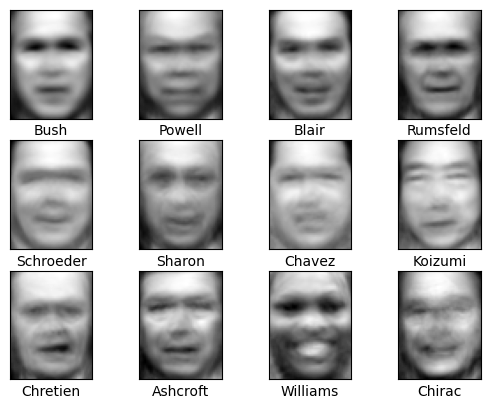

In [611]:
fig, ax = plt.subplots(3, 4)
for i, axi in enumerate(ax.flat):
    img, lbl = get_img_by_row(df_photo.iloc[i])
    axi.imshow(img, cmap='gray')
    axi.set(xticks=[], yticks=[],
            xlabel=lbl.split()[-1])
plt.savefig('persons_pics_img_for_description.png', dpi = 100, bbox_inches='tight')

В качестве меры "схожести" двух объектов часто используют так называемое [косинусное сходство](https://en.wikipedia.org/wiki/Cosine_similarity). Не следует путать с косинусным расстоянием.

Постройте матрицу "схожести" объектов на основе их усредненных векторов. Для визуализации рекомендуем использовать тепловую карту, например, [из библиотеки seaborn](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

<Axes: >

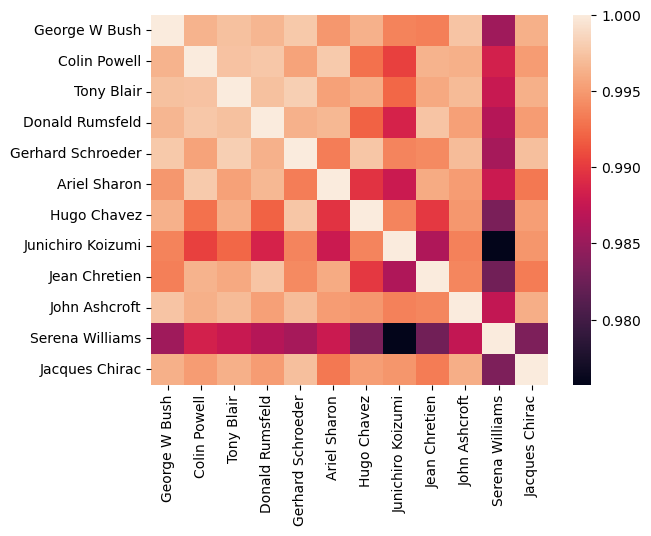

In [612]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Предположим, что у вас есть DataFrame df_photo с вашими данными
name = df_photo['label']
vectors = df_photo.drop(columns='label')
matrix_res = np.zeros((len(vectors), len(vectors)))

for j in range(len(vectors)):
    for i in range(len(vectors)):
        a = np.array(vectors.iloc[j])
        b = np.array(vectors.iloc[i])
        cosine = cosine_similarity(a.reshape(1, -1), b.reshape(1, -1))
        matrix_res[j][i] = cosine[0][0]

# Создаем тепловую карту с подписанными осями
sns.heatmap(matrix_res, xticklabels=name, yticklabels=name)



In [613]:
vectors = df_photo.drop(columns='label')

a = np.array(vectors.iloc[11])
b = np.array(vectors.iloc[7])
cosine = cosine_similarity(a.reshape(1, -1), b.reshape(1, -1))


Определите косинусное сходство для пары людей из вашего индивидуального задания на основе соответствующих им "усредненных" векторов.

In [614]:
print(*cosine)

[0.9947458]


# Построение модели

При помощи <code>train_test_split()</code> разделите набор данных на тренировочный и тестовый с параметрами, указанными в вашем индивидуальном задании. Используйте стратификацию по колонке <code>label</code>.

In [615]:
X = df.drop(columns='label')
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11, stratify=y)


## Первое приближение: базовый SVM классификатор с линейным ядром.

Обучите модель <code>SVC()</code> на тренировочном наборе данных с параметрами, указанными в вашем индивидуальном задании.

In [616]:
svc = SVC(kernel='linear', random_state=11)
svc.fit(X_train, y_train)
pred = svc.predict(X_test) 

Оцените модель на тестовых данных. Вычислите <code>f1_score(average='weighted')</code>

In [617]:
f1_score(y_test, pred, average='weighted')

0.7838258158689967

В целом, достаточно неплохой результат, но имеет смысл попробовать подобрать параметры.

## Подбор гиперпараметров

Используя <code>GridSearchCV()</code>, осуществите подбор гиперпараметров, указанных в вашем задании. Отдельно обратите внимание на время обучения моделей

In [618]:
tuned_parameters = [{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000], 'class_weight': [None, 'balanced'], 'random_state':[11]}]

cv = GridSearchCV(SVC(), tuned_parameters, refit=True, verbose=3)

Определите гиперпараметры лучшей полученной модели.

In [619]:
cv.fit(X_train, y_train)
cv.best_params_

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=11;, score=0.807 total time=   0.6s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=11;, score=0.792 total time=   0.6s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=11;, score=0.769 total time=   0.6s
[CV 4/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=11;, score=0.797 total time=   0.5s
[CV 5/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=11;, score=0.764 total time=   0.5s
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=11;, score=0.349 total time=   0.7s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=11;, score=0.358 total time=   0.7s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=11;, score=0.368 total time=   0.8s
[CV 4/5] END C=1, class_weight=N

{'C': 100,
 'class_weight': 'balanced',
 'gamma': 0.001,
 'kernel': 'rbf',
 'random_state': 11}

Выполните предсказание для тестовых данных при помощи лучшей полученной модели. Вычислите <code>f1_score(average='weighted')</code>.

In [620]:
svc = SVC(C = 100,
 class_weight='balanced',
 gamma=0.001,
 kernel='rbf',
 random_state=11)
svc.fit(X_train, y_train)
pred = svc.predict(X_test)

f1_score(y_test, pred, average='weighted')

0.8104755950985177

## Уменьшение размерности

Обучение было долгим. Имеет смысл проверить, что будет если уменьшить размерность входных данных, например, при помощи <code>PCA</code>. Обучите модель <code>PCA(svd_solver='full')</code> на тренировочных данных и определите минимальное количество компонент, необходимое для того, чтобы уровень объясненной дисперсии был больше <code>0.95</code>.

In [621]:
from sklearn.decomposition import PCA

In [622]:
model_PCA = PCA(svd_solver='full')
data_transformed = model_PCA.fit_transform(X_train)
explained_var = np.cumsum(model_PCA.explained_variance_ratio_)
components = np.arange(1, len(explained_var)+1)



In [623]:
np.where(explained_var>0.95)[0][0]+1

172

Заново обучите модель <code>PCA(svd_solver='full')</code> на тренировочных данных с использованием полученного числа ГК. Примените полученное преобразование для тренировочных и тестовых данных.

In [624]:
model_PCA = PCA(svd_solver='full', n_components=172)
model_PCA.fit(X_train)
X_train = model_PCA.transform(X_train)
X_test = model_PCA.transform(X_test)


Для полученных после <code>PCA</code> данных аналогично проделанному ранее, то есть используя <code>GridSearchCV()</code>, осуществите подбор гиперпараметров, указанных в вашем задании. Отдельно обратите внимание на время обучения моделей.

In [625]:
tuned_parameters = [{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000], 'class_weight': [None, 'balanced'], 'random_state':[11]}]

cv = GridSearchCV(SVC(), tuned_parameters, refit=True, verbose=3)

Определите гиперпараметры лучшей полученной модели.

In [626]:
cv.fit(X_train, y_train)
cv.best_params_

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=11;, score=0.788 total time=   0.1s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=11;, score=0.783 total time=   0.1s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=11;, score=0.722 total time=   0.1s
[CV 4/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=11;, score=0.783 total time=   0.1s
[CV 5/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=11;, score=0.717 total time=   0.1s
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=11;, score=0.340 total time=   0.1s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=11;, score=0.344 total time=   0.1s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=11;, score=0.340 total time=   0.1s
[CV 4/5] END C=1, class_weight=N

{'C': 100,
 'class_weight': None,
 'gamma': 0.001,
 'kernel': 'rbf',
 'random_state': 11}

Выполните предсказание для тестовых данных при помощи лучшей полученной модели. Вычислите <code>f1_score(average='weighted')</code>

In [630]:
svc = SVC(C = 100,
 class_weight= None,
 gamma=0.001,
 kernel='rbf',
 random_state=11)
svc.fit(X_train, y_train)
pred = svc.predict(X_test)

f1_score(y_test, pred, average='weighted')

0.8100342068273005

Видно, что качество модели изменилось незначительно, при этом время обучения существенно сократилось.